# GNSS NLOS Detection Dataset Generator - Code Walkthrough

This notebook provides a detailed explanation of the `GenDataset.py` script, which generates a synthetic dataset for GNSS (Global Navigation Satellite System) NLOS (Non-Line-of-Sight) detection. The dataset simulates satellite signals in different environments (urban, suburban, and open sky) with various characteristics like SNR (Signal-to-Noise Ratio), elevation angle, azimuth, constellation type, and NLOS status.

## Overview of the Code Structure

The code is structured into several major components:

1. **Satellite Data Generation**: Functions to generate realistic satellite positions across the sky
2. **Environment Simulation**: Functions to simulate different environments (urban, suburban, open sky)
3. **Building Effects**: Logic to model how buildings block satellite signals
4. **Signal Properties**: Generation of realistic SNR values based on satellite characteristics
5. **Visualization**: Various plots to explore the generated dataset
6. **Statistics**: Calculation and display of dataset statistics

Let's import the necessary libraries first.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

# Create figures directory if it doesn't exist
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

## 1. Satellite Sky Distribution Generation

First, let's examine the function that generates a realistic distribution of satellites across the sky. This function creates elevation and azimuth angles that model where satellites would typically be visible from a ground location.

In [2]:
def generate_sky_distribution(n_samples):
    """
    Generate a realistic distribution of satellites across the sky
    
    Parameters:
    n_samples (int): Number of satellite observations to generate
    
    Returns:
    tuple: (elevation, azimuth) arrays with satellite positions in degrees
    """
    # Generate elevation angles (more satellites at higher elevations)
    # Using a beta distribution skewed toward higher elevations
    elevation = np.random.beta(2, 1.5, n_samples) * 90
    
    # Generate azimuth angles (uniform distribution around the horizon)
    azimuth = np.random.uniform(0, 360, n_samples)
    
    return elevation, azimuth

Let's visualize the sky distribution to understand what it looks like:

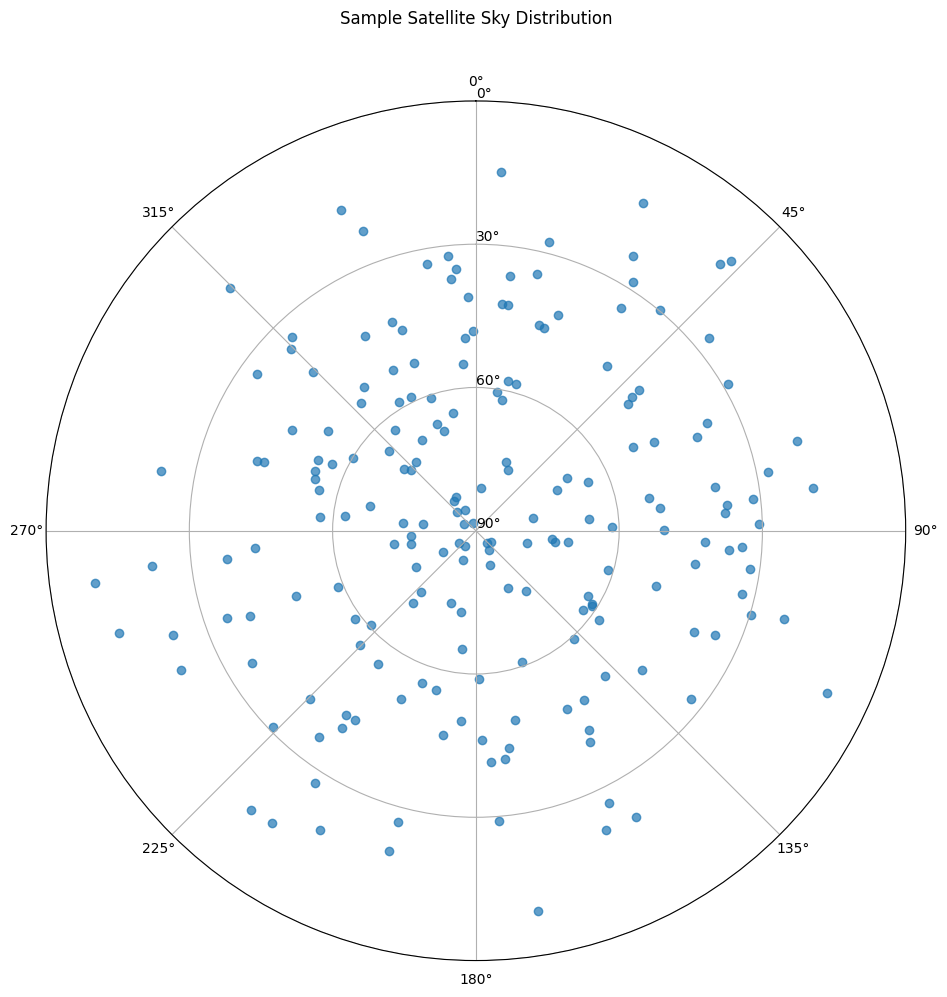

In [3]:
# Generate a sample distribution
sample_elevation, sample_azimuth = generate_sky_distribution(200)

# Plot using a polar projection
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')

# Convert azimuth to radians for polar plotting
azimuth_rad = np.deg2rad(sample_azimuth)

# In polar plots, 90-elevation gives the radial distance from center
radial_distance = 90 - sample_elevation

# Create scatter plot
ax.scatter(azimuth_rad, radial_distance, alpha=0.7)

# Configure the polar plot
ax.set_theta_zero_location('N')  # 0 degrees at the top (North)
ax.set_theta_direction(-1)       # Clockwise direction
ax.set_rlabel_position(0)        # Radial labels at 0 degrees
ax.set_rticks([0, 30, 60, 90])   # Radial ticks
ax.set_rlim(0, 90)               # Limit radial range
ax.set_yticklabels(['90°', '60°', '30°', '0°'])  # Elevation labels

plt.title('Sample Satellite Sky Distribution', y=1.08)
plt.tight_layout()
plt.show()

## 2. Building Effects Simulation

Next, let's examine the function that simulates how buildings block satellite signals. This function takes information about building locations, heights, and widths, and determines which satellites are blocked.

In [4]:
def add_buildings(elevation, azimuth, building_directions, building_heights, building_widths):
    """
    Simulate buildings blocking satellite signals
    
    Parameters:
    elevation (array): Satellite elevation angles
    azimuth (array): Satellite azimuth angles
    building_directions (list): List of building directions in degrees of azimuth
    building_heights (list): List of building heights in degrees of elevation
    building_widths (list): List of building widths in degrees of azimuth
    
    Returns:
    array: Boolean mask where True indicates the satellite is blocked by a building
    """
    n_satellites = len(elevation)
    is_blocked = np.zeros(n_satellites, dtype=bool)
    
    for direction, height, width in zip(building_directions, 
                                       building_heights, 
                                       building_widths):
        # Calculate angular distance to building direction (considering circular azimuth)
        az_distance = np.minimum(
            np.abs(azimuth - direction),
            360 - np.abs(azimuth - direction)
        )
        
        # Satellite is blocked if it's behind the building and below its height
        is_blocked = is_blocked | (
            (az_distance <= width / 2) & (elevation <= height)
        )
    
    return is_blocked

To visualize how the building blocking works, let's create a simple urban environment and show which satellites are blocked:

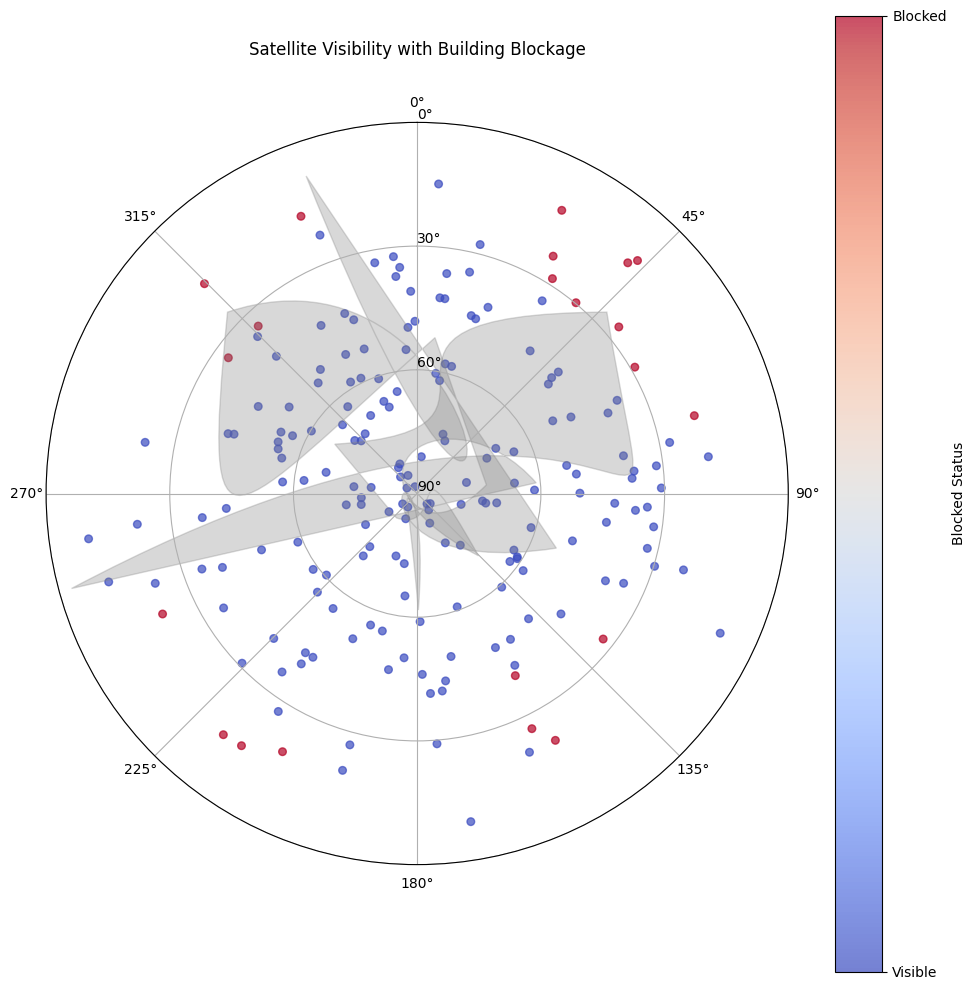

In [5]:
# Define simple building environment
building_directions = [45, 135, 225, 315]  # Buildings in NE, SE, SW, NW
building_heights = [30, 40, 25, 35]        # Heights in degrees elevation
building_widths = [60, 40, 50, 45]         # Widths in degrees azimuth

# Determine which satellites are blocked
blocked_satellites = add_buildings(sample_elevation, sample_azimuth, 
                                  building_directions, building_heights, building_widths)

# Visualize the blocking effect
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')

# Convert to polar coordinates
azimuth_rad = np.deg2rad(sample_azimuth)
radial_distance = 90 - sample_elevation

# Plot satellites, coloring by blocked status
scatter = ax.scatter(azimuth_rad, radial_distance, c=blocked_satellites, 
                    cmap='coolwarm', alpha=0.7, s=30)

# Draw the building regions
for direction, height, width in zip(building_directions, building_heights, building_widths):
    # Calculate the edges of the building in azimuth
    left_edge = direction - width/2
    right_edge = direction + width/2
    
    # Draw the building as a colored wedge
    wedge = plt.matplotlib.patches.Wedge(
        center=(0, 0),
        r=90-0,  # From center to 90 degrees from zenith
        theta1=left_edge,
        theta2=right_edge,
        width=90-height,  # Width from full extension to building height
        alpha=0.3,
        color='grey'
    )
    ax.add_artist(wedge)

# Configure the polar plot
ax.set_theta_zero_location('N')  # 0 degrees at the top
ax.set_theta_direction(-1)       # Clockwise
ax.set_rlabel_position(0)
ax.set_rticks([0, 30, 60, 90])
ax.set_rlim(0, 90)
ax.set_yticklabels(['90°', '60°', '30°', '0°'])  # Elevation labels

# Add legend
cbar = plt.colorbar(scatter, label='Blocked Status')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Visible', 'Blocked'])

plt.title('Satellite Visibility with Building Blockage', y=1.08)
plt.tight_layout()
plt.show()

## 3. Signal-to-Noise Ratio (SNR) Generation

The SNR is a critical parameter for satellite signal quality. Let's examine the function that generates realistic SNR values based on satellite characteristics and NLOS status.

In [6]:
def generate_snr(elevation, constellation, is_nlos):
    """
    Generate realistic SNR values based on elevation, constellation, and NLOS status
    
    Parameters:
    elevation (array): Satellite elevation angles
    constellation (array): Satellite constellation indicators (1-4)
    is_nlos (array): Boolean indicator of NLOS status
    
    Returns:
    array: Simulated SNR values
    """
    n_satellites = len(elevation)
    
    # Base SNR increases with elevation angle
    base_snr = 25 + (20 * elevation / 90)
    
    # Add constellation-specific offsets
    constellation_offset = np.zeros(n_satellites)
    constellation_offset[constellation == 1] = 2  # GPS
    constellation_offset[constellation == 2] = 0  # GLONASS
    constellation_offset[constellation == 3] = 3  # Galileo
    constellation_offset[constellation == 4] = 1  # BeiDou
    
    # Add random variations
    snr = base_snr + constellation_offset + np.random.normal(0, 2, n_satellites)
    
    # Reduce SNR for NLOS signals
    nlos_reduction = np.random.uniform(5, 15, n_satellites)
    snr[is_nlos] -= nlos_reduction[is_nlos]
    
    # Add some noise to make the relationship non-linear
    snr += np.random.normal(0, 2, n_satellites)
    
    # Ensure SNR stays in a realistic range
    snr = np.clip(snr, 15, 55)
    
    return snr

Let's visualize how SNR relates to elevation and NLOS status:

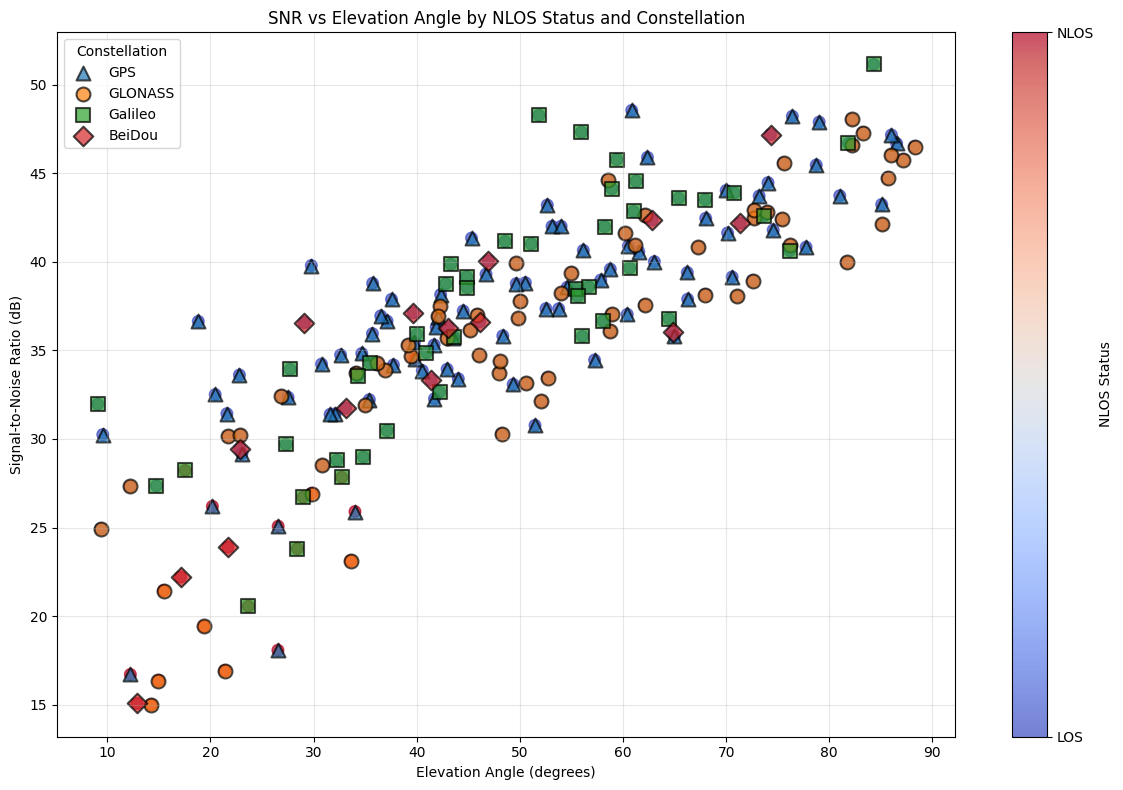

In [7]:
# Generate constellation types
sample_constellation = np.random.choice([1, 2, 3, 4], size=200, p=[0.4, 0.3, 0.2, 0.1])
# Generate SNR values
sample_snr =generate_snr(sample_elevation, sample_constellation, blocked_satellites)

# Create a scatter plot to visualize SNR vs elevation
plt.figure(figsize=(12, 8))
scatter = plt.scatter(sample_elevation, sample_snr, c=blocked_satellites, 
                     cmap='coolwarm', alpha=0.7, s=70)

# Add constellation markers
for i, const in enumerate([1, 2, 3, 4]):
    mask = sample_constellation == const
    if np.any(mask):
        plt.scatter(sample_elevation[mask], sample_snr[mask], 
                   marker='^' if const==1 else 'o' if const==2 else 's' if const==3 else 'D',
                   s=100, edgecolors='black', linewidth=1.5, alpha=0.7,
                   label=f"{'GPS' if const==1 else 'GLONASS' if const==2 else 'Galileo' if const==3 else 'BeiDou'}")

# Add legend and labels
plt.legend(title="Constellation")
plt.colorbar(scatter, label='NLOS Status', ticks=[0, 1], 
            format=plt.FuncFormatter(lambda x, pos: 'LOS' if x < 0.5 else 'NLOS'))
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Signal-to-Noise Ratio (dB)')
plt.title('SNR vs Elevation Angle by NLOS Status and Constellation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Pseudorange Bias and Error Simulation
Now let's examine the functions that generate pseudorange biases for NLOS signals, which represent the additional path length due to signal reflection.

In [8]:
def generate_pseudorange_bias(is_nlos, elevation):
    """
    Generate pseudorange biases for NLOS signals
    
    Parameters:
    is_nlos (array): Boolean indicators for NLOS status
    elevation (array): Satellite elevation angles in degrees
    
    Returns:
    array: Pseudorange biases in meters
    """
    n_satellites = len(is_nlos)
    bias = np.zeros(n_satellites)
    
    # Only NLOS signals have bias
    nlos_indices = np.where(is_nlos)[0]
    
    if len(nlos_indices) > 0:
        # Higher elevation typically means smaller bias
        elevation_factor = 1.0 - (elevation[nlos_indices] / 90.0) * 0.7
        
        # Generate positive biases (signal path is always longer)
        # Lower satellites can have much larger biases
        bias[nlos_indices] = np.random.exponential(
            10 + 30 * elevation_factor, 
            size=len(nlos_indices)
        )
        
        # Add some random variations
        bias[nlos_indices] += np.random.normal(0, 3, len(nlos_indices))
         # Ensure all biases are positive
        bias[nlos_indices] = np.maximum(1.0, bias[nlos_indices])
    
    return bias

def generate_pseudorange_error(is_nlos, constellation, elevation, snr):
    """
    Generate pseudorange measurement errors based on signal quality
    
    Parameters:
    is_nlos (array): Boolean indicators for NLOS status
    constellation (array): Satellite constellation identifiers
    elevation (array): Satellite elevation angles in degrees
    snr (array): Signal-to-noise ratio values
    
    Returns:
    array: Pseudorange measurement errors in meters
    """
    n_satellites = len(is_nlos)
    error = np.zeros(n_satellites)
    
    for i in range(n_satellites):
        # Base error depends on constellation and SNR
        if constellation[i] == 1:  # GPS
            base_error = 1.5
        elif constellation[i] == 2:  # GLONASS
            base_error = 2.0
        elif constellation[i] == 3:  # Galileo
            base_error = 1.7
        else:  # BeiDou
            base_error = 2.2
        
        # SNR contribution - lower SNR means higher error
        snr_factor = 20.0 / max(20.0, snr[i])
        
        # Elevation contribution - lower elevation means higher error
        elev_factor = 1.0 + (1.0 - min(elevation[i], 60.0) / 60.0) * 0.8
        
        # NLOS contribution - NLOS signals have higher noise
        nlos_factor = 2.0 if is_nlos[i] else 1.0
        
        # Calculate standard deviation for this measurement
        std_dev = base_error * snr_factor * elev_factor * nlos_factor
        
        # Generate random error
        error[i] = np.random.normal(0, std_dev)
    
    return error

Now let's generate pseudorange biases and errors for our sample data:

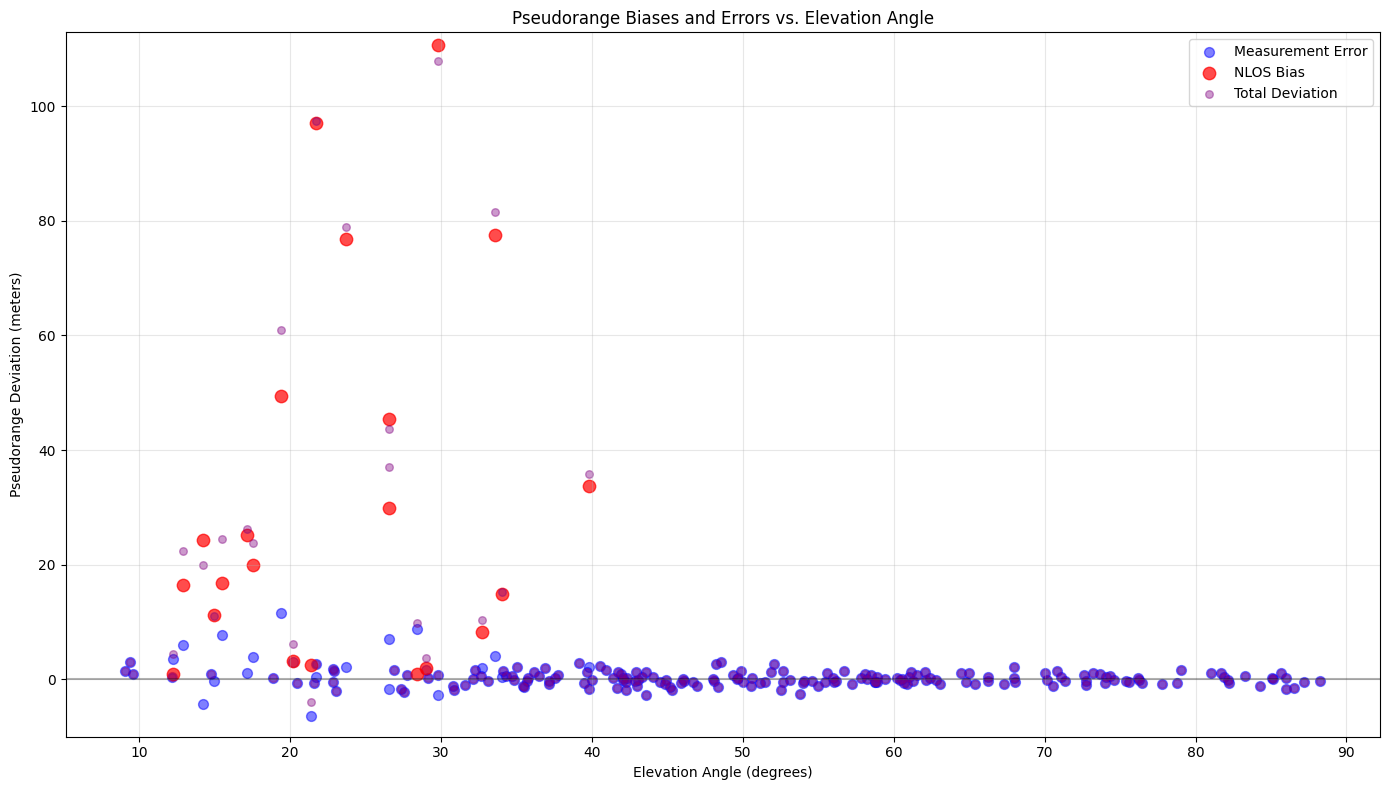

In [9]:
# Generate pseudorange biases for NLOS signals
sample_bias = generate_pseudorange_bias(blocked_satellites, sample_elevation)

# Generate pseudorange measurement errors
sample_error = generate_pseudorange_error(blocked_satellites, 
                                         sample_constellation, 
                                         sample_elevation, 
                                         sample_snr)

# Calculate total pseudorange deviation (bias + error)
total_deviation = sample_bias + sample_error

# Create a visualization of the pseudorange deviations
plt.figure(figsize=(14, 8))

# Scatter plot for errors (smaller markers)
plt.scatter(sample_elevation, sample_error, c='blue', alpha=0.5, s=50, label='Measurement Error')

# Scatter plot for NLOS biases (larger markers)
nlos_indices = np.where(blocked_satellites)[0]
if len(nlos_indices) > 0:
    plt.scatter(sample_elevation[nlos_indices], sample_bias[nlos_indices], 
                c='red', alpha=0.7, s=80, label='NLOS Bias')

# Scatter plot for total deviation
plt.scatter(sample_elevation, total_deviation, c='purple', alpha=0.4, s=30, label='Total Deviation')

# Add labels and legend
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Pseudorange Deviation (meters)')
plt.title('Pseudorange Biases and Errors vs. Elevation Angle')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.ylim(-10, max(50, np.max(total_deviation) + 5))
plt.tight_layout()
plt.show()

## 5. Position Calculation with NLOS Signals
Now let's implement a simple position calculation algorithm and evaluate the impact of NLOS signals:

In [10]:
def calculate_position_error(satellites, biases, errors):
    """
    Simulate position calculation and return position error magnitude
    
    Parameters:
    satellites (array): Array of satellite elevation and azimuth angles
    biases (array): Pseudorange biases in meters
    errors (array): Measurement errors in meters
    
    Returns:
    float: Estimated position error in meters
    """
    # Number of satellites
    n_satellites = len(biases)
    
    # For simplicity, we'll use a linear model where each satellite's
    # contribution to position error is weighted by its geometry
    
    # Approximate geometric dilution of precision (GDOP)
    # In reality, this would come from the satellite geometry matrix
    elevation_rad = np.radians(satellites)
    
    # Higher elevations generally provide better vertical accuracy
    vertical_contrib = np.sum(np.sin(elevation_rad)) / n_satellites
    
    # Spread of satellites improves horizontal accuracy
    # We're using a simplified model here
    horizontal_contrib = np.sqrt(n_satellites) / 4
    
    # Combine to get a simple GDOP approximation (lower is better)
    simplified_gdop = 2.0 / (vertical_contrib + horizontal_contrib)
    
    # Calculate measurement residuals (bias + error)
    residuals = biases + errors
    
    # RMS of residuals
    rms_residual = np.sqrt(np.mean(np.square(residuals)))
    
    # Estimated position error
    position_error = simplified_gdop * rms_residual
    
    return position_error



Let's run a simulation to compare position errors with and without NLOS signals:

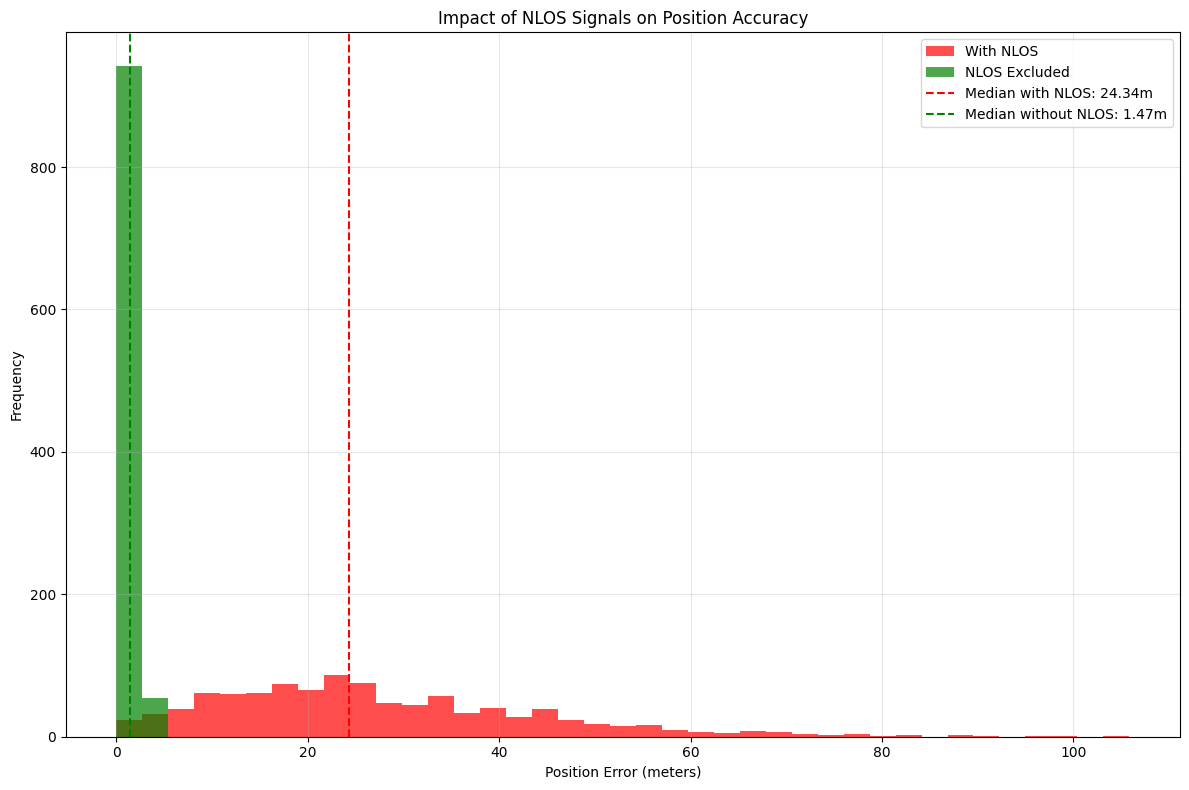

With NLOS signals:
  Mean error: 27.39 meters
  Median error: 24.34 meters
  95th percentile: 58.69 meters

Without NLOS signals (NLOS excluded):
  Mean error: 1.60 meters
  Median error: 1.47 meters
  95th percentile: 2.80 meters


In [11]:
def run_position_simulation(n_simulations=1000):
    """
    Run multiple simulations to compare position errors with and without NLOS signals
    
    Parameters:
    n_simulations (int): Number of simulation runs
    
    Returns:
    tuple: Arrays of errors with and without NLOS signals
    """
    errors_with_nlos = []
    errors_without_nlos = []
    
    for _ in range(n_simulations):
        # Generate random elevation angles (10 to 90 degrees)
        elevation = np.random.uniform(10, 90, size=12)
        
        # Generate random constellation types
        constellation = np.random.choice([1, 2, 3, 4], size=12, p=[0.4, 0.3, 0.2, 0.1])
        
        # Simulate NLOS conditions for some satellites
        is_nlos = np.random.rand(12) < (0.6 - 0.5 * elevation / 90.0)
        
        # Generate SNR values
        snr = generate_snr(elevation, constellation, is_nlos)
        
        # Generate biases and errors
        bias = generate_pseudorange_bias(is_nlos, elevation)
        error = generate_pseudorange_error(is_nlos, constellation, elevation, snr)
        
        # Calculate position error with NLOS signals
        error_with_nlos = calculate_position_error(elevation, bias, error)
        errors_with_nlos.append(error_with_nlos)
        
        # Calculate position error without NLOS signals
        # We'll only use LOS satellites
        los_indices = np.where(~is_nlos)[0]
        if len(los_indices) >= 4:  # Need at least 4 satellites for position
            error_without_nlos = calculate_position_error(
                elevation[los_indices], 
                bias[los_indices], 
                error[los_indices]
            )
            errors_without_nlos.append(error_without_nlos)
        
    return np.array(errors_with_nlos), np.array(errors_without_nlos)

# Run the simulation
errors_with_nlos, errors_without_nlos = run_position_simulation(1000)

# Visualize the results
plt.figure(figsize=(12, 8))

# Plot histograms
bins = np.linspace(0, max(np.max(errors_with_nlos), np.max(errors_without_nlos)) + 2, 40)
plt.hist(errors_with_nlos, bins=bins, alpha=0.7, label='With NLOS', color='red')
plt.hist(errors_without_nlos, bins=bins, alpha=0.7, label='NLOS Excluded', color='green')

# Add labels and legend
plt.xlabel('Position Error (meters)')
plt.ylabel('Frequency')
plt.title('Impact of NLOS Signals on Position Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=np.median(errors_with_nlos), color='red', linestyle='--', 
           label=f'Median with NLOS: {np.median(errors_with_nlos):.2f}m')
plt.axvline(x=np.median(errors_without_nlos), color='green', linestyle='--',
           label=f'Median without NLOS: {np.median(errors_without_nlos):.2f}m')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"With NLOS signals:")
print(f"  Mean error: {np.mean(errors_with_nlos):.2f} meters")
print(f"  Median error: {np.median(errors_with_nlos):.2f} meters")
print(f"  95th percentile: {np.percentile(errors_with_nlos, 95):.2f} meters")
print(f"\nWithout NLOS signals (NLOS excluded):")
print(f"  Mean error: {np.mean(errors_without_nlos):.2f} meters")
print(f"  Median error: {np.median(errors_without_nlos):.2f} meters")
print(f"  95th percentile: {np.percentile(errors_without_nlos, 95):.2f} meters")

This simulation clearly demonstrates the impact of NLOS signals on positioning accuracy and the potential benefits of NLOS detection and exclusion algorithms.